In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l
import time
import pathlib
data_dir = 'C:/Users/eaind/ocr/13Sep21Model/cnnpro/data/'


class Inception(tf.keras.Model):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        
        self.p1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',activation='relu')
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',activation='relu')
        self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')
        
    def get_config(self):
        cfg = super().get_config()
        return cfg  

    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension
        return tf.keras.layers.Concatenate()([p1, p2, p3, p4])

In [3]:
def b1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])


def b2():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation='relu'),
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])


def b3():
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])


def b4():
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])


def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()
    ])


def net():
    return tf.keras.Sequential([b1(), b2(), b3(), b4(), b5(),
                                tf.keras.layers.Dense(39)])


X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 39)


In [4]:
img_height = 96
img_width = 96
batch_size = 128

train_iter = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_iter = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21897 files belonging to 39 classes.
Using 17518 files for training.
Found 21897 files belonging to 39 classes.
Using 4379 files for validation.


In [5]:

class TrainCallback(tf.keras.callbacks.Callback):  
    """A callback to visiualize the training progress."""
    def __init__(self, net, train_iter, val_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.num_epochs = num_epochs
        self.device_name = device_name
    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()
    def on_epoch_end(self, epoch, logs):
        if(logs.get('loss')<0.02):
            print("\nReached 98% accuracy so cancelling training!")
            self.net.stop_training = True
        self.timer.stop()
        test_acc = self.net.evaluate(self.val_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, 'f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on 'f'{str(self.device_name)}')


def train_ch6(net_fn, train_iter, val_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, val_iter, num_epochs, device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net

loss 0.244, train acc 0.925, test acc 0.904
33.9 examples/sec on /CPU:0


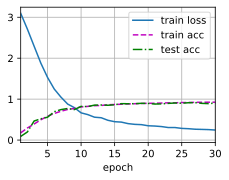

In [6]:
lr = 0.001
num_epochs = 30
model = train_ch6(net, train_iter, val_iter, num_epochs, lr, d2l.try_gpu())

In [7]:
model.save('savemodel/ggnet_ep30lr0p001bs128')

INFO:tensorflow:Assets written to: savemodel/ggnet_ep30lr0p001bs128\assets


In [8]:
loadmodel = tf.keras.models.load_model('savemodel/ggnet_ep30lr0p001bs128')

loadmodel.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 24, 24, 64)        9472      
_________________________________________________________________
sequential_7 (Sequential)    (None, 12, 12, 192)       114944    
_________________________________________________________________
sequential_8 (Sequential)    (None, 6, 6, 480)         552432    
_________________________________________________________________
sequential_9 (Sequential)    (None, 3, 3, 832)         2809168   
_________________________________________________________________
sequential_10 (Sequential)   (None, 1024)              2487536   
_________________________________________________________________
dense_1 (Dense)              (None, 39)                39975     
Total params: 6,013,527
Trainable params: 6,013,527
Non-trainable params: 0
___________________________________________

In [11]:
loss, acc = loadmodel.evaluate(val_iter, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(loadmodel.predict(val_iter).shape)

35/35 - 19s - loss: 0.6670 - accuracy: 0.8095
Restored model, accuracy: 80.95%
(4379, 39)


In [ ]:
###Testing###

In [ ]:
###Testing###

In [ ]:
###Testing###

In [12]:
import cv2
import os
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf

# class names
class_names = ['၀','၁','၂','၃','၄','၅','၆','၇','၈','၉','အ','ဘ',')','ဒ','ဓ','ဂ','ဟ','ထ','ဌ','က','ခ','လ','မ','န','င','ည','(','ပ','ဖ','ဆ','/','စ','တ','သ','ဥ','ဝ','ရ','ယ','ဇ']

# image folder
folder = 'C:/Users/eaind/ocr/13Sep21Model/cnnpro/data/ka/'

# dimensions of images
img_width, img_height = 96, 96

In [13]:
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
        #plt.imshow(img)
        #plt.show()
        img_resize = cv2.resize(img, (img_width, img_height))
        img_resize_2 = img_resize.reshape(1, 96, 96, 3)
        pred = loadmodel.predict(img_resize_2)
        cls = class_names[np.argmax(pred)]
        print("Prediction of " + filename + " is  " + cls)
        

Prediction of ka_0.jpg is  က
Prediction of ka_1.jpg is  က
Prediction of ka_10.jpg is  ဘ
Prediction of ka_100.jpg is  လ
Prediction of ka_1000.jpg is  ဘ
Prediction of ka_1001.jpg is  က
Prediction of ka_1002.jpg is  က
Prediction of ka_1003.jpg is  က
Prediction of ka_1004.jpg is  က
Prediction of ka_1005.jpg is  က
Prediction of ka_1006.jpg is  က
Prediction of ka_1007.jpg is  က
Prediction of ka_1008.jpg is  လ
Prediction of ka_1009.jpg is  က
Prediction of ka_101.jpg is  က
Prediction of ka_1010.jpg is  က
Prediction of ka_1011.jpg is  က
Prediction of ka_1012.jpg is  က
Prediction of ka_1013.jpg is  လ
Prediction of ka_1014.jpg is  က
Prediction of ka_1015.jpg is  က
Prediction of ka_1016.jpg is  က
Prediction of ka_1017.jpg is  လ
Prediction of ka_1018.jpg is  ၇
Prediction of ka_1019.jpg is  က
Prediction of ka_102.jpg is  က
Prediction of ka_1020.jpg is  က
Prediction of ka_1021.jpg is  က
Prediction of ka_1022.jpg is  လ
Prediction of ka_1023.jpg is  က
Prediction of ka_1024.jpg is  က
Prediction of ka_10

Prediction of ka_1231.jpg is  က
Prediction of ka_1232.jpg is  က
Prediction of ka_1233.jpg is  က
Prediction of ka_1234.jpg is  က
Prediction of ka_1235.jpg is  လ
Prediction of ka_124.jpg is  က
Prediction of ka_125.jpg is  က
Prediction of ka_126.jpg is  က
Prediction of ka_127.jpg is  က
Prediction of ka_128.jpg is  က
Prediction of ka_129.jpg is  က
Prediction of ka_13.jpg is  က
Prediction of ka_130.jpg is  က
Prediction of ka_131.jpg is  က
Prediction of ka_132.jpg is  က
Prediction of ka_133.jpg is  က
Prediction of ka_134.jpg is  က
Prediction of ka_135.jpg is  က
Prediction of ka_136.jpg is  က
Prediction of ka_137.jpg is  က
Prediction of ka_138.jpg is  က
Prediction of ka_139.jpg is  က
Prediction of ka_14.jpg is  က
Prediction of ka_140.jpg is  က
Prediction of ka_141.jpg is  က
Prediction of ka_142.jpg is  က
Prediction of ka_143.jpg is  က
Prediction of ka_144.jpg is  ဘ
Prediction of ka_145.jpg is  က
Prediction of ka_146.jpg is  က
Prediction of ka_147.jpg is  က
Prediction of ka_148.jpg is  က
Predi

Prediction of ka_359.jpg is  က
Prediction of ka_36.jpg is  က
Prediction of ka_360.jpg is  က
Prediction of ka_361.jpg is  က
Prediction of ka_362.jpg is  က
Prediction of ka_363.jpg is  က
Prediction of ka_364.jpg is  လ
Prediction of ka_365.jpg is  က
Prediction of ka_366.jpg is  က
Prediction of ka_367.jpg is  က
Prediction of ka_368.jpg is  က
Prediction of ka_369.jpg is  က
Prediction of ka_37.jpg is  က
Prediction of ka_370.jpg is  က
Prediction of ka_371.jpg is  က
Prediction of ka_372.jpg is  က
Prediction of ka_373.jpg is  က
Prediction of ka_374.jpg is  က
Prediction of ka_375.jpg is  က
Prediction of ka_376.jpg is  က
Prediction of ka_377.jpg is  က
Prediction of ka_378.jpg is  က
Prediction of ka_379.jpg is  က
Prediction of ka_38.jpg is  က
Prediction of ka_380.jpg is  က
Prediction of ka_381.jpg is  က
Prediction of ka_382.jpg is  က
Prediction of ka_383.jpg is  က
Prediction of ka_384.jpg is  က
Prediction of ka_385.jpg is  က
Prediction of ka_386.jpg is  က
Prediction of ka_387.jpg is  လ
Prediction 

Prediction of ka_6.jpg is  တ
Prediction of ka_60.jpg is  က
Prediction of ka_600.jpg is  က
Prediction of ka_601.jpg is  ဆ
Prediction of ka_602.jpg is  ဘ
Prediction of ka_603.jpg is  က
Prediction of ka_604.jpg is  က
Prediction of ka_605.jpg is  က
Prediction of ka_606.jpg is  က
Prediction of ka_607.jpg is  က
Prediction of ka_608.jpg is  က
Prediction of ka_609.jpg is  က
Prediction of ka_61.jpg is  က
Prediction of ka_610.jpg is  က
Prediction of ka_611.jpg is  က
Prediction of ka_612.jpg is  က
Prediction of ka_613.jpg is  လ
Prediction of ka_614.jpg is  က
Prediction of ka_615.jpg is  က
Prediction of ka_616.jpg is  က
Prediction of ka_617.jpg is  က
Prediction of ka_618.jpg is  က
Prediction of ka_619.jpg is  ဆ
Prediction of ka_62.jpg is  က
Prediction of ka_620.jpg is  က
Prediction of ka_621.jpg is  က
Prediction of ka_622.jpg is  က
Prediction of ka_623.jpg is  က
Prediction of ka_624.jpg is  က
Prediction of ka_625.jpg is  လ
Prediction of ka_626.jpg is  က
Prediction of ka_627.jpg is  က
Prediction of

Prediction of ka_84.jpg is  က
Prediction of ka_840.jpg is  က
Prediction of ka_841.jpg is  က
Prediction of ka_842.jpg is  က
Prediction of ka_843.jpg is  က
Prediction of ka_844.jpg is  က
Prediction of ka_845.jpg is  က
Prediction of ka_846.jpg is  က
Prediction of ka_847.jpg is  က
Prediction of ka_848.jpg is  က
Prediction of ka_849.jpg is  က
Prediction of ka_85.jpg is  က
Prediction of ka_850.jpg is  က
Prediction of ka_851.jpg is  က
Prediction of ka_852.jpg is  က
Prediction of ka_853.jpg is  က
Prediction of ka_854.jpg is  က
Prediction of ka_855.jpg is  က
Prediction of ka_856.jpg is  က
Prediction of ka_857.jpg is  က
Prediction of ka_858.jpg is  က
Prediction of ka_859.jpg is  က
Prediction of ka_86.jpg is  လ
Prediction of ka_860.jpg is  က
Prediction of ka_861.jpg is  က
Prediction of ka_862.jpg is  က
Prediction of ka_863.jpg is  က
Prediction of ka_864.jpg is  က
Prediction of ka_865.jpg is  က
Prediction of ka_866.jpg is  က
Prediction of ka_867.jpg is  က
Prediction of ka_868.jpg is  က
Prediction 